In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import Audio

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

SAMPLING_RATE = 48_000 / 8

import sys
sys.path.append('../')
import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,surprised,strong,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.007500,2.498167,[1.0788441e-05 3.7551079e-02 3.6168553e-02 ......,[1.0788441e-05 3.7551045e-02 3.6168423e-02 ......,0,2872,3920,4536,5536,6480,7136,8936
1,speech,surprised,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.024167,2.357167,[8.6426735e-06 1.0938305e-02 7.4250461e-03 ......,[8.6426735e-06 1.0938293e-02 7.4250125e-03 ......,0,1544,2528,4032,5224,5984,6712,7992
2,speech,angry,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.029333,2.467500,[1.1563301e-05 4.1558143e-02 2.8845785e-02 ......,[1.15633011e-05 4.15581055e-02 2.88456734e-02 ...,0,2992,4368,4912,5896,6768,7400,8624
3,speech,fearful,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.030500,2.710000,[2.0563602e-06 1.1770763e-02 5.6602592e-03 ......,[2.0563602e-06 1.1770754e-02 5.6602429e-03 ......,0,4576,5064,6240,7544,8248,8784,10072
4,speech,fearful,strong,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.047667,3.127167,[6.9618225e-05 1.3387279e-02 8.0524459e-02 ......,[6.9618225e-05 1.3387272e-02 8.0524310e-02 ......,0,1984,2504,3648,5176,8320,10256,12472


In [4]:
## Import only the required stuff to prevent memory overload
traces_dict = dict()
for syll in [0,2]:
    file_path = os.path.join(TS_PREPROC_FOLDER, f"syllables_{syll}_ts.npy")
    traces_dict[f"syllables_{syll}_ts"] = np.load(file_path, allow_pickle=True)
# traces_dict["clean_trace"] = np.load( os.path.join(TS_PREPROC_FOLDER, "clean_trace.npy"), allow_pickle=True)
traces_dict.keys()

dict_keys(['syllables_0_ts', 'syllables_2_ts'])

In [5]:
traces_dict['syllables_0_ts'] = [ tr[~np.isnan(tr)] for tr in traces_dict['syllables_0_ts']]

Audio(traces_dict['syllables_0_ts'][0], rate=SAMPLING_RATE)

In [6]:
traces_dict['syllables_2_ts'] = [ tr[~np.isnan(tr)] for tr in traces_dict['syllables_2_ts']]

Audio(traces_dict['syllables_2_ts'][0], rate=SAMPLING_RATE)

In [7]:
# Concatenate syll0 and syll2
new_traces = [np.concatenate((traces_dict['syllables_0_ts'][i], traces_dict['syllables_2_ts'][i])) for i in range(len(traces_dict['syllables_0_ts'])) ]

Audio(new_traces[0], rate=SAMPLING_RATE)

1552


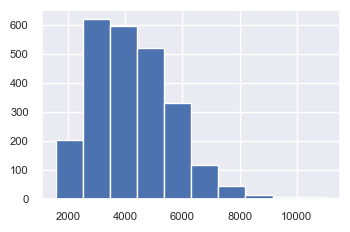

In [8]:
# Check distribution f lentgths
plt.hist([len(x) for x in new_traces]);
print(min([len(x) for x in new_traces]))

# Fourier stuff

In [127]:
from djanloo_fourier import STFTransformer

transf = STFTransformer(n_time_bins=None, 
                        n_spectral_bins=None, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE)

# Makes a square STFT
transf.balance_n_coeff(new_traces)
transf.report(new_traces)

Time bins = 27, Spectral bins = 27
min length of trace is roughly 57
max number of Fourier coeffs is 28


In [128]:
STFT, SC = transf.fit_transform(new_traces)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:55<00:00, 43.79it/s]


/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


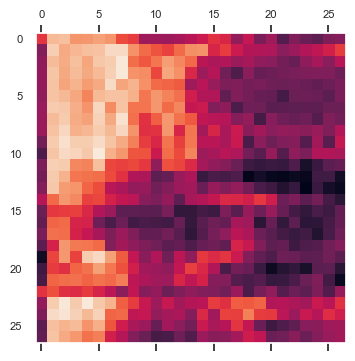

In [11]:
test_track_indx = 80
plt.matshow(STFT[test_track_indx])
plt.grid(ls="")
plt.title(f"statement = {df.statement[test_track_indx]}")

In [12]:
traces_dict['syllables_0_2_stft'] = STFT
traces_dict['syllables_0_2_sc'] = SC

for t in ['syllables_0_2_sc', 'syllables_0_2_stft']:
    np.save(os.path.join(TS_PREPROC_FOLDER, f'{t}.npy'), traces_dict[t])

## Check umap

In [187]:
from umap import UMAP

# Flattens each image
X = STFT.reshape(-1, transf.n_spectral_bins*transf.n_time_bins)
reducer = UMAP(n_neighbors=50, n_jobs=-1)
embedding = reducer.fit_transform(X)

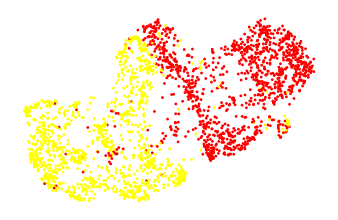

In [188]:
plt.scatter(*embedding.T, c=(df.statement=="dogs"), cmap="autumn", s=1)
plt.axis("off");

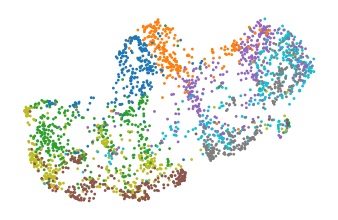

In [189]:
labels = [f"{row.sex}{row.vocal_channel}{row.statement}" for idx, row in df.iterrows()]
labels = pd.Categorical(labels).codes

plt.scatter(*embedding.T, c=labels, cmap="tab10", s=1)
plt.axis("off");